# Simulation

In [1]:
# %load ./../../../games/connect-four/connect-four.py
import numpy as np

class ConnectFourSimulator:
	"""Creates a connect-4 board and simulates it, returning states and rewards for any taken action.

	The creates board is a 6 x 7 (rows x cols) array. Empty fields are denoted by 0.
	Tokens placed by player one are denoted by '1' and player two uses '-1'.
	Every field is part of the state and has it's own index, simply counting from 0 to 41 along the rows
	like so [
		[0, 1, 2, 3, 4, 5, 6],
		[7, 8, 9, 10, 11, 12, 13],
		...
		[35, 36, 37, 38, 39, 40, 41]
	]
	"""
	def __init__(self):
		self.width = 7
		self.height = 6
		self.board = np.zeros(shape=(self.height, self.width))
		self.PLAYER1 = 1
		self.PLAYER2 = -1
		self.DRAW = 0
		self.current_player = self.PLAYER1
		self.__game_over = False

	def take_action(self, action):
		"""Executes the action and returns the next state and the received reward."""
		active_player = self.current_player
		inactive_player = self.__negated_player(active_player)
		if not self.__action_is_valid(action):
			return self.__game_over, np.copy(self.board), active_player, -2, inactive_player, 0

		self.__play_move(action)

		self.__game_over = self.__game_is_over(action)
		if self.__game_over:
			winner = self.__winner(action)
			if winner == self.DRAW:
				return self.__game_over, np.copy(self.board), active_player, 0, inactive_player, 0
			elif winner == self.PLAYER1:
				return self.__game_over, np.copy(self.board), active_player, 100, inactive_player, -100
			else:
				return self.__game_over, np.copy(self.board), active_player, -100, inactive_player, 100

		return self.__game_over, np.copy(self.board), active_player, 0, inactive_player, 0

	def print_board(self):
		#print(self.board)
		board = self.board
		board = np.where(board == 1, "X", board)
		board = np.where(board == "-1.0", "O", board)
		print(np.where(board == "0.0", "-", board))

	def __play_move(self, action):
		"""Takes an action and executes it."""
		x, y = self.__coordinates_from_action(action)
		self.board[y][x] = self.current_player
		self.current_player = self.__negated_player(self.current_player)

	def __action_is_valid(self, action):
		"""Checks if the intended action is a valid one or if it breaks the rules of the game."""
		if 41 > action < 0:
			return False
		x, y = self.__coordinates_from_action(action)
		if x >= self.width or y >= self.height:
			return False

		height_x = self.__column_height(x)

		if y != height_x:
			return False
		return True

	def __column_height(self, x):
		"""Returns the height of a column which is equal to the amount of tokens placed."""
		column = self.board[:, x]
		return np.count_nonzero(column)

	def __game_is_over(self, last_action):
		"""Returns True if the game is over and False otherwise."""
		if np.count_nonzero(self.board) >= 42:
			return True

		lines = self.__extract_lines(last_action)

		for line in lines:
			if self.__winner_in_line(line) != 0:
				return True

		return False

	def __extract_lines(self, last_action):
		"""Extracts the horizontal, vertical and the diagonal lines going through the last action"""
		x, y = self.__coordinates_from_action(last_action)

		row = self.board[y]
		column = self.board[:, x]
		top_down_diagonal = self.board.diagonal(x - y)

		mirrored_x = self.width - 1 - x
		bot_up_diagonal = np.fliplr(self.board).diagonal(mirrored_x - y)

		return row, column, top_down_diagonal, bot_up_diagonal

	def __winner(self, last_action):
		"""Returns the winner's number or 0 if the game resulted in a draw (Requires the game to have ended)."""
		lines = self.__extract_lines(last_action)

		for line in lines:
			winner = self.__winner_in_line(line)
			if winner != 0:
				return winner

		return 0

	def __winner_in_line(self, line):
		"""Checks if a line contains a winner and returns his number if yes and 0 otherwise."""
		token_sum = 0
		for token in line:
			token_sum += token
			if token_sum == 4 * self.PLAYER1:
				return self.PLAYER1
			if token_sum == 4 * self.PLAYER2:
				return self.PLAYER2
			if token_sum < 0 < token or token_sum > 0 > token:
				token_sum = 0
		return 0

	def __coordinates_from_action(self, action):
		"""Translates an action into (x, y) / (column, row) coordinates."""
		x = action % self.width
		y = action // self.width
		return x, y

	def __negated_player(self, player):
		"""Returns the player not passed to the function (Player1 if Player2 is passed and the other way around)."""
		return self.PLAYER2 if self.current_player == self.PLAYER1 else self.PLAYER1


In [2]:
game = ConnectFourSimulator()

val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    val = input()

print(game.take_action(3))
print(game.take_action(4))
print(game.take_action(10))
print(game.take_action(5))
print(game.take_action(17))
print(game.take_action(6))
print(game.take_action(24))

# Agent

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(42, 64)
        #self.fc1.weight.data.fill_(0.0)
        #self.fc1.bias.data.fill_(0.0)
        self.fc2 = nn.Linear(64, 64)
        #self.fc2.weight.data.fill_(0.0)
        #self.fc2.bias.data.fill_(0.0)
        self.fc3 = nn.Linear(64, 42)
        #self.fc3.weight.data.fill_(0.0)
        #self.fc3.bias.data.fill_(0.0)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
import random

import torch
import torch.optim as optim

class DeepQPytorchAgent:
    def __init__(self, learning_rate=0.0001, discount=0.95, exploration_rate=1.0, iterations=10_000, trained_model=None):
        self.q_table = np.zeros(shape=(42, 42))
        self.learning_rate = learning_rate
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.exploration_delta = exploration_rate / iterations
        
        self.input_count = 42
        self.output_count = 42
        
        self.define_model(trained_model)
    
    def define_model(self, trained_model):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if trained_model:
            self.model = trained_model.to(self.device)
        else:
            self.model = Model().to(self.device)
        
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def get_Q(self, state):
        x = torch.tensor(state.flatten(), device=self.device).float()
        return self.model(x)
        
    def next_action(self, state):
        if random.random() < self.exploration_rate:
            return self.random_action()
        else:
            return self.greedy_action(state)
        
    def random_action(self):
        return random.randrange(0, 42) # Maybe change the probability distribution?
    
    def greedy_action(self, state):
        #print("Greedy1:", torch.max(self.get_Q(state), 0)[0])
        #print("Greedy2:", torch.max(self.get_Q(state), 0)[1])
        return torch.max(self.get_Q(state), 0)[1]
    
    def update(self, old_state, new_state, action, reward):
        self.train(old_state, new_state, action, reward)
        # TODO: Maybe change algorithm?
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.2, self.exploration_rate - self.exploration_delta)
        
    def train(self, old_state, new_state, action, reward):
        old_state_values = self.get_Q(old_state)
        new_state_values = self.get_Q(new_state)
        
        new_reward = reward + self.discount * torch.max(new_state_values)
        updated_state_values = torch.tensor(old_state_values)
        updated_state_values[action] = new_reward
        
        
        old_state_values = torch.tensor(old_state_values, device=self.device).float()
        updated_state_values = torch.tensor(updated_state_values, device=self.device).float()
        # in your training loop:
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss = torch.autograd.Variable(F.smooth_l1_loss(old_state_values, updated_state_values), requires_grad=True)
        loss.backward()
        self.optimizer.step()    # Does the update

In [5]:
import random
import tensorflow as tf
import numpy as np

import torch
import torch.optim as optim


class DeepQTensorflowAgent:
    def __init__(self, learning_rate=0.1, discount=0.95, exploration_rate=1.0, iterations=10_000):
        self.q_table = np.zeros(shape=(42, 42))
        self.learning_rate = learning_rate
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.exploration_delta = exploration_rate / iterations
        
        self.input_count = 42
        self.output_count = 42
        
        self.session = tf.Session()
        self.define_model()
        self.session.run(self.initializer)
    
    def define_model(self):
        self.model_input = tf.placeholder(dtype=tf.float32, shape=[ None, self.input_count ])
        
        fc1 = tf.layers.dense(self.model_input, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((self.input_count, 5))))
        fc2 = tf.layers.dense(fc1, 16, activation=tf.sigmoid, kernel_initializer=tf.constant_initializer(np.zeros((6, self.output_count))))
        
        self.model_output = tf.layers.dense(fc2, self.output_count)
        
        self.target_output = tf.placeholder(shape=[ None, self.output_count ], dtype=tf.float32)
        loss = tf.losses.mean_squared_error(self.target_output, self.model_output)
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(loss)
        
        self.initializer = tf.global_variables_initializer()
    
    def get_Q(self, state):
        # Batching!! Dimensions!
        return self.session.run(self.model_output, feed_dict={ self.model_input: [state.flatten()] })[0]
        
    def next_action(self, state):
        if random.random() < self.exploration_rate:
            return self.random_action()
        else:
            return self.greedy_action(state)
        
    def random_action(self):
        return random.randrange(0, 42) # Maybe change the probability distribution?
    
    def greedy_action(self, state):
        return np.argmax(self.get_Q(state))
    
    def update(self, old_state, new_state, action, reward):
        self.train(old_state, new_state, action, reward)
        # TODO: Maybe change algorithm?
        if self.exploration_rate > 0:
            self.exploration_rate = max(0.05, self.exploration_rate - self.exploration_delta)
        
    def train(self, old_state, new_state, action, reward):
        old_state_values = self.get_Q(old_state)
        new_state_values = self.get_Q(new_state)
        
        new_reward = reward + self.discount * np.amax(new_state_values)
        old_state_values[action] = new_reward
        
        training_input = [old_state.flatten()]
        target_output = [ old_state_values ]
        training_data = { self.model_input: training_input, self.target_output: target_output }
        
        self.session.run(self.optimizer, feed_dict=training_data)

# Orchestration

In [6]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('old_state', 'next_state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
def transition(game, active, passive):
    old_state = game.board
    action = active.next_action(old_state)
    
    game_over, new_state, _, reward, _, _ = game.take_action(action)
        
    if game_over:
        return True, old_state, new_state, action, reward
            
    # if the move was invalid, add data and repeat
    if reward < 0:
        return False, old_state, new_state, action, reward
        
    # Play another move until the move is a right one and add the data to the memory
    passive_reward = -1
    counting_stars = 0
    while passive_reward < 0:
        passive_action = passive.next_action(new_state)
        game_over, _, _, passive_reward, _, cur_reward = game.take_action(passive_action)
        
        counting_stars += 1
        if counting_stars % 1000 == 0:
                print("Counting:", counting_stars)
        
    if game_over:
        return True, old_state, new_state, action, cur_reward
    return False, old_state, new_state, action, reward

In [8]:
def optimize_model(active, passive, memory, batch_size=128):
    if len(memory) < batch_size:
        return active, passive
    
    batch = memory.sample(batch_size)
    
    for transition in batch:
        active.update(*transition)
        
    model = active.model
    active = DeepQPytorchAgent(iterations=iterations, exploration_rate=active.exploration_rate, trained_model=model)
    passive = DeepQPytorchAgent(iterations=iterations, exploration_rate=active.exploration_rate, trained_model=model)
    return active, passive

In [9]:
game = ConnectFourSimulator()

val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    game.print_board()
    print("------------------------------------")
    val = input()

In [10]:
#print("Input:", input())

In [11]:
iterations = 20_000

#deep_Q_learning = DeepQPytorchAgent(iterations=iterations)
#deep_Q_dummy = DeepQPytorchAgent(iterations=iterations)

deep_Q_learning = DeepQPytorchAgent(iterations=iterations)
deep_Q_dummy = DeepQTensorflowAgent(iterations=iterations)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val = torch.tensor(0).to(device)
print(val)
print(game.board)
game.take_action(val)
print(game.board)

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [13]:
epochs = 100 # Number of games to play
batch_size = 128
memory = ReplayMemory(10000)
active = DeepQPytorchAgent(iterations=iterations)
passive = DeepQPytorchAgent(iterations=iterations)

In [41]:
test = [[0]]*6
test

[[0], [0], [0], [0], [0], [0]]

In [43]:
test[0].append(2)
test

[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]

In [14]:
# Using memory replay
total_rewards = [ [0] for epoch in epochs ]
total = [0]
print(total_rewards)
for epoch in range(epochs):
    #invalids = []
    #invalid = 0
    #for iteration in range(1, iterations + 1):
    print("Epoch:", epoch)
    game_over = False
    game = ConnectFourSimulator()
    while not game_over:
        optimize_model(active, passive, memory, batch_size)
            

        #if iteration % 100 == 0:
        #    invalids.append(invalid)
        #    invalid = 0
        #if iteration % 250 == 0:
        #    print("Iteration:", iteration)
                      
        game_over, old_state, action, next_state, reward = transition(game, active, passive)
        if reward != -2:
            memory.push(old_state, action, next_state, reward)
            total_rewards[epoch].append(total_rewards[epoch][-1] + reward)
            total.append(total[-1] + reward)

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11


c:\users\linus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\linus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\linus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99


In [36]:
print(len(total_rewards))
print(len(total_rewards[0]))
print(total_rewards[0])

100
1106
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -200, -200, -200, -200, -200, -200, -200, -200, -300, -300, -300, -300, -300, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -500, -500, -500, -500, -500, -500, -500, -500, -600, -600, -600, -600, -600, -600, -600, -600, -600, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -800, -800, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -900, -900, -900, -900, -900, -900, -900, -900, -900, -900, -900, -90

In [22]:
print(len(total))
print(total)

1106
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -200, -200, -200, -200, -200, -200, -200, -200, -300, -300, -300, -300, -300, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -300, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -400, -500, -500, -500, -500, -500, -500, -500, -500, -600, -600, -600, -600, -600, -600, -600, -600, -600, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -800, -800, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -700, -700, -700, -700, -700, -700, -700, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -800, -900, -900, -900, -900, -900, -900, -900, -900, -900, -900, -900, -900, -

<IPython.core.display.Javascript object>


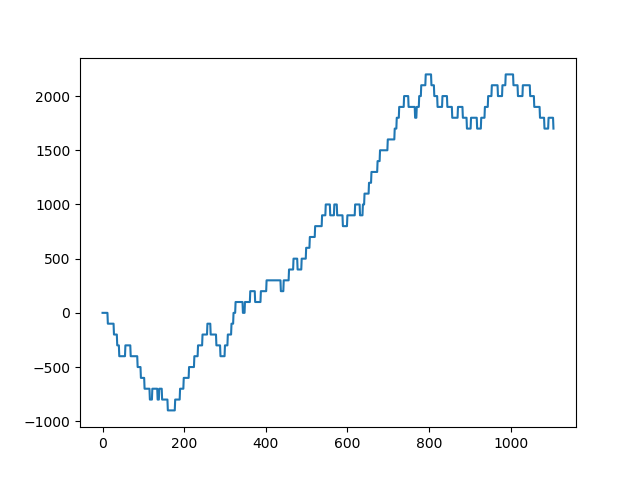

In [16]:
plt.figure()
#plt.plot(total_rewards[0])
plt.plot(total)

print(invalids)

invalids = []
invalid = 0
for step in range(10000):
    if step % 250 == 0:
        print("Still running at iteration", step)
        
    
    old_state = game.board
    action = deep_Q_learning.next_action(old_state)
    game_over, new_state, cur_player, cur_reward, _, _ = game.take_action(action)
    
    if (step + 1) % 100 == 0:
            invalids.append(invalid)
            invalid = 0
    if cur_reward < 0: # Invalid action
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
        invalid += 1
        continue
        
    #print(game_over)
    #print(new_state)
    #print(cur_player)
    #print(cur_reward)
    
    if game_over:
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
        game = ConnectFourSimulator()
        continue
    
    next_action = deep_Q_dummy.next_action(new_state)
    game_over, next_state, _, active_reward, passive_player, passive_reward = game.take_action(action)
    
    counting_stars = 0
    while active_reward < 0: # Invalid move (infinite loop possible?)
        next_action = deep_Q_dummy.next_action(new_state)
        game_over, next_state, _, active_reward, passive_player, passive_reward = game.take_action(next_action)
        counting_stars += 1
        if counting_stars % 1000 == 0:
            print("Counting:", counting_stars)
            print("Using action:", action)
    
    #print(game_over)
    #print(next_state)
    #print(passive_player)
    #print(passive_reward)
    
    if game_over:
        deep_Q_learning.update(old_state, new_state, action, passive_reward)
        game = ConnectFourSimulator()
    else:
        deep_Q_learning.update(old_state, new_state, action, cur_reward)
    # Missing: check for invalid move
    # Maybe add passive mode to game (for the 2nd player)
    #print("----------------------------")
        
print("Invalids:", invalids)
print("Total:", sum(invalids))

In [17]:
# Error in the end comes from the network predicting a result, which is wrong and since exploration is way down it almost
# always predicts the same action which is always wrong. Should somehow learn though (maybe replay necessary?)

# Notes
- Use memory replay
- Maybe higher rewards needed for backpropagation of Q values?
- View reward function by playing vs the network
- View network output for certain states
<br>
- Do I even backpropagate the reward to other states than the winning one in any way?
- Maybe the problem are few games (not enough possibilities learned) -> More iterations like 10_000 games instead of iterations
- Learning rate?
<br>
<br>
- Rework memory replay batch size and epochs anolog to pytorch tutorial
- Plot metrics (e.g. total reward every iteration)
- Rework code --> Readability and reusability
- Maybe rework greedy policy
- Test the pytorch agent on the dungeon example
- Try increasing the performance (For running in the cloud) -> Use timer
- Maybe no punishment for invalid moves?
- Pass possible moves to network?
- Only give out copies of the state... --> FIXED (This literally ruined every single state in the memory...)
<br>
<br>
- Too many states, how should he ever learn from a previously recieved reward if the state never occurs again?? --> Probably from similar ones?

In [44]:
empty_board = np.zeros(shape=(6, 7))

In [45]:
example_board = np.array([
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,1,-1,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0]
])

In [46]:
print(active.next_action(example_board))
print(active.get_Q(example_board))
print(torch.max(active.get_Q(example_board), 0)[1])

tensor(3, device='cuda:0')
tensor([ 5.7235e-01, -7.5124e-02,  3.4640e-01,  7.6801e-01, -1.9371e-01,
        -4.7315e-02,  3.2235e-01, -3.4378e-02, -2.2581e-01, -3.0638e-01,
        -5.2390e-01,  2.0962e-01, -1.1484e-01,  3.1978e-02,  9.7560e-02,
        -1.9366e-01, -3.0864e-01,  8.3320e-02,  2.7765e-01, -3.0449e-01,
        -2.0376e-01,  1.8988e-01,  3.5383e-01, -5.3854e-01, -1.7224e-01,
         5.7994e-02, -5.5375e-01, -1.5726e-01,  2.7686e-01,  5.4099e-04,
         1.2531e-01,  3.8313e-02, -1.5334e-01,  2.8466e-02,  1.1601e-01,
         4.3877e-02, -1.1450e-01,  1.2682e-01, -6.2352e-01,  2.1899e-01,
        -4.3293e-01,  8.2397e-02], device='cuda:0', grad_fn=<AddBackward0>)
tensor(3, device='cuda:0')


In [47]:
print(active.next_action(empty_board))
print(active.get_Q(empty_board))
print(torch.max(active.get_Q(empty_board), 0)[1])

tensor(3, device='cuda:0')
tensor([ 0.5807, -0.0768,  0.3500,  0.7652, -0.1986, -0.0451,  0.3283, -0.0320,
        -0.2312, -0.3052, -0.5310,  0.2143, -0.1093,  0.0370,  0.1002, -0.1953,
        -0.3115,  0.0847,  0.2844, -0.3046, -0.2083,  0.1845,  0.3577, -0.5427,
        -0.1683,  0.0498, -0.5552, -0.1558,  0.2759, -0.0036,  0.1229,  0.0376,
        -0.1542,  0.0338,  0.1027,  0.0446, -0.1149,  0.1257, -0.6290,  0.2280,
        -0.4268,  0.0836], device='cuda:0', grad_fn=<AddBackward0>)
tensor(3, device='cuda:0')


In [49]:
game = ConnectFourSimulator()
val = input()
while val != "q":
    game_over, board, _, _, _, _ = game.take_action(int(val))
    print(game_over)
    print(board)
    print("------------------------------------")
    if not game_over:
        confirmation = "r"
        while confirmation == "r":
            pc_action = active.next_action(board)
            print(pc_action)
            confirmation = input()
            if confirmation == "c":
                game_over, board, _, _, _, _ = game.take_action(pc_action)
                print(game_over)
                print(board)
    val = input()

3
False
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
------------------------------------
tensor(3, device='cuda:0')
q
q


In [50]:
games = memory.sample(len(memory))

In [53]:
terminal_states = [ game for game in games if game[3] == 100 or game[3] == -100 ]

In [60]:
for state in terminal_states:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("---------------------------------------")

Before:
 [[-1. -1. -1.  1.  1.  1.  1.]
 [ 1.  0. -1. -1.  1. -1.  1.]
 [-1.  0. -1.  1. -1.  0. -1.]
 [-1.  0.  0. -1.  1.  0.  1.]
 [ 1.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.]]
After:
 [[-1. -1. -1.  1.  1.  1.  1.]
 [ 1.  0. -1. -1.  1. -1.  1.]
 [-1.  0. -1.  1. -1.  0. -1.]
 [-1.  0.  0. -1.  1.  0.  1.]
 [ 1.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. -1.]]
With action: 31
---------------------------------------
Before:
 [[-1.  1.  1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1. -1. -1.]
 [ 0.  0. -1.  0. -1.  1.  1.]
 [ 0.  0.  1.  0. -1.  1. -1.]
 [ 0.  0.  0.  0.  0.  1.  0.]]
After:
 [[-1.  1.  1.  1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1. -1. -1.]
 [ 0.  0. -1.  0. -1.  1.  1.]
 [ 0.  0.  1.  0. -1.  1. -1.]
 [ 0.  0.  0.  0.  0.  1.  0.]]
With action: 34
---------------------------------------
Before:
 [[ 1. -1.  1.  1. -1.  1.  0.]
 [ 1.  0. -1. -1.  1. -1.  0.]
 [ 0.  0.  1.  1.  1.  1.  0.]
 [ 0

In [61]:
for state in memory.memory[:42]:
    print("Before:\n", state[0])
    print("After:\n", state[1])
    print("With action:", state[2])
    print("Reward:", reward)
    print("---------------------------------------")

Before:
 [[ 1. -1. -1.  1.  1.  1. -1.]
 [-1.  0. -1. -1.  1. -1.  1.]
 [ 1.  0.  0.  1.  1.  1. -1.]
 [ 0.  0.  0. -1. -1.  1. -1.]
 [ 0.  0.  0.  1.  1. -1.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]]
After:
 [[ 1. -1. -1.  1.  1.  1. -1.]
 [-1.  0. -1. -1.  1. -1.  1.]
 [ 1.  0.  0.  1.  1.  1. -1.]
 [ 0.  0.  0. -1. -1.  1. -1.]
 [ 0.  0.  0.  1.  1. -1.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]]
With action: 4
Reward: -100
---------------------------------------
Before:
 [[ 1. -1. -1.  1.  1.  1. -1.]
 [-1.  0. -1. -1.  1. -1.  1.]
 [ 1.  0.  0.  1.  1.  1. -1.]
 [ 0.  0.  0. -1. -1.  1. -1.]
 [ 0.  0.  0.  1.  1. -1.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]]
After:
 [[ 1. -1. -1.  1.  1.  1. -1.]
 [-1.  0. -1. -1.  1. -1.  1.]
 [ 1.  0.  0.  1.  1.  1. -1.]
 [ 0.  0.  0. -1. -1.  1. -1.]
 [ 0.  0.  0.  1.  1. -1.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.]]
With action: 5
Reward: -100
---------------------------------------
Before:
 [[ 1. -1. -1.  1.  1.  1. -1.]
 [-1.  0. -1. -1.  1. -1.  1.]
 [ 1.  0.  